
## EARTHQUAKE PREDICTION
# AN ANALYSIS ON LABORATORY EARTHQUAKES

Forecasting earthquakes is one of the most important problems in Earth science because of their devastating consequences. Earthquake casualties are, in general, the result of the total or partial collapse of buildings, and falling non-structural elements. The higher tolls are usually concentrated in developing countries where innovative seismic-resistant and engineering technologies are not applied. 
To mitigate the consequences and reduce losses, early warning systems have been developed worldwide. These systems issue timely alerts to populations before the hazard occurs, allowing them to take protective measures. The earthquake waves used in these alert systems are the incoming P waves. P waves travel fastest and are the first to arrive 
from the earthquake. These waves are followed by S waves. In rock, S waves generally travel about 60% the speed of P waves, and the S wave always arrives after the P wave.
Warning for incoming S waves can give people time to take precautions; they can also be used in automated devices like in chemical and industrial factories to prevent cascading events, like fire or toxic material spills.
An example of these alert systems is the one that UC Berkeley, with the collaboration of Google, is testing. It consists of an application that can record, with the end-user's permission, a smartphone or table’s GPS position and movements. The innovative system can distinguish seismic waves recorded from other types of movements.
In the last couple of decades, several algorithms were tested to identify the sources of seismic events, projected ground motion level and the lead time for S waves arrival (e.g., EPIC, previously named ElarmS v3.0, or FinDer). These algorithms are continuously under test and improvement to enhance their performance.
The data set used in this analysis was provided by The Los Alamos National laboratory together with Kaggle competition. This is a challenging data set that based on laboratory analysis gives the opportunity to explore when an earthquake will occur. This kind of analysis has the potential to help researchers to improve earthquake hazard assessments that could save lives and billions of dollars in infrastructure.


## Exploratory Data Analysis.


The data training is a single, continuous segment of experimental data. 
The data set consists of two variables, acustic_data that is the seismic signal and time_to_failure that is the time (in seconds) until the next laboratory earthquake. In this analysis I will address when the earthquake will take place. Specifically, predict the time remaining before laboratory earthquakes occur from real-time seismic data.


In [4]:
#Common packages:
import os
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

To do EDA I will take a sample of the first 100 million data.

In [74]:
#try:
train_data = pd.read_csv('train.csv',nrows=100000000, dtype={'acoustic_data': np.int16},error_bad_lines=False)
                           #nrows=100000000, dtype={'acoustic_data': np.int16})
                           #index_col=0)
 # print('Success: Data loaded into dataframe.')
print("Dataframe shape:", train_data .shape)
#except Exception as e:
 #   print('Data load error: ',e)

Dataframe shape: (100000000, 2)


In [42]:
from tsfresh import extract_features
from tsfresh.feature_extraction import MinimalFCParameters, EfficientFCParameters
from tqdm import tqdm
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute

from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR
from sklearn.metrics import mean_absolute_error

In [17]:
pd.options.display.precision = 12
train_data.head(10)



,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


In [18]:
train_data.describe()

,acoustic_data,time_to_failure
count,1.000000e+08,1.000000e+08
mean,4.648496e+00,6.447961e+00
std,1.041905e+01,3.842484e+00
min,-4.621000e+03,6.954822e-04
25%,2.000000e+00,3.120298e+00
50%,5.000000e+00,6.366700e+00
75%,7.000000e+00,9.613998e+00
max,3.914000e+03,1.418060e+01


In [24]:
#train_data.acoustic_data.nunique()
train_data['acoustic_data_type'] = pd.Categorical(train_data.acoustic_data)

train_data.dtypes




acoustic_data            int16
time_to_failure        float64
acoustic_data_type    category
dtype: object

If we remove the pick values we can see that the acoustic data seems to have a normal distribution.

/Users/jose1/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


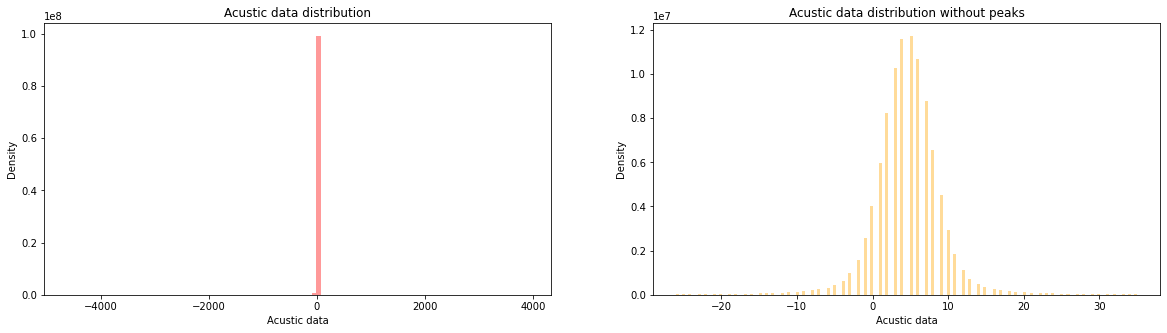

In [32]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
sns.distplot(train_data.acoustic_data.values, ax=ax[0], color="Red", bins=100, kde=False)
ax[0].set_xlabel("Acustic data")
ax[0].set_ylabel("Density")
ax[0].set_title("Acustic data distribution")

low = train_data.acoustic_data.mean() - 3 * train_data.acoustic_data.std()
high = train_data.acoustic_data.mean() + 3 * train_data.acoustic_data.std() 
sns.distplot(train_data.loc[(train_data.acoustic_data >= low) & (train_data.acoustic_data <= high), "acoustic_data"].values,
             ax=ax[1],
             color="Orange",
             bins=150, kde=False)
ax[1].set_xlabel("Acustic data")
ax[1].set_ylabel("Density")
ax[1].set_title("Acustic data distribution without peaks");

In [35]:
#Helper function to graph acoustic data with time to failure.
def make_dualline(df):
    fig, ax1 = plt.subplots()
    plt.title('Acoustic Data and Time to Failure', fontsize=30)

    color = 'tab:orange'
    ax1.set_xlabel('index', fontsize=25)
    ax1.set_ylabel('Time to Failure', color=color, fontsize=20)
    
    ax1.plot(df['time_to_failure'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('Acoustic Data', color=color, fontsize=20)  # we already handled the x-label with ax1
    ax2.plot(df['acoustic_data'], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()



We can see that large values of acoustic data can represent an earthquake. And we can also see how the time to failure relates to the acoustic data.

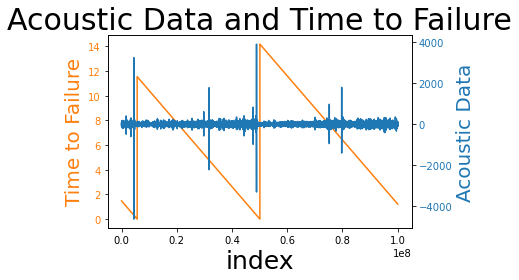

In [36]:
make_dualline(train_data)

In [27]:
#Print the percent of unique values per column. Use the df.nunique and the size of the dataframe to calculate 
#the percentages.
total=len(train_data)
print(total)
train_unique=train_data.nunique()
percentage_unique=train_unique/total
print(train_unique)
print(percentage_unique)

100000000
acoustic_data             3119
time_to_failure       99620548
acoustic_data_type        3119
dtype: int64
acoustic_data         0.000031
time_to_failure       0.996205
acoustic_data_type    0.000031
dtype: float64


The data set does not have any missing values. And we are keeping all the extreme values observed in order to capture the earthquake events.

In [22]:
#Run the code below to print out the percent of each feature that is missing.
nas=pd.DataFrame(train_data.isnull().sum().sort_values(ascending=False)/len(train_data),columns = ['percent'])
pos = nas['percent'] > 0
nas[pos]

,percent


## Modeling

Due to processing limitations modeling will be done with 3.17% of the data (20 million readings). 

In [22]:
#try:
train_short = pd.read_csv('train.csv',nrows=20000000, dtype={'acoustic_data': np.int16},error_bad_lines=False)
                           #nrows=100000000, dtype={'acoustic_data': np.int16})
                           #index_col=0)
 # print('Success: Data loaded into dataframe.')
print("Dataframe shape:", train_short .shape)
#except Exception as e:
 #   print('Data load error: ',e)
#train_short=train_whole.head(2000000)

Dataframe shape: (20000000, 2)


In an attempt to find an effective model, I am going to apply a feature extraction technique called tsfresh. 
Tsfresh is a python package that is used to automatically calculate a huge number of features. The package contains methods to evaluate the explaining power and importance of such characteristics for our regression task.

Groups of 5000 rows will be used by tsfresh to combine them in different ways in order to extract new features. I will add an identifier to be able to distinguish each group of 5000 data points.

In [23]:
# First Segment
rows = 50000
idlist = []
for n in range(1,401):  #400 segments
    idlist = idlist + [n for i in range(rows)]



In [31]:
train_short['id']=idlist
print(train_short.head())    
train_short.tail()

   acoustic_data  time_to_failure  id
0             12           1.4691   1
1              6           1.4691   1
2              8           1.4691   1
3              5           1.4691   1
4              8           1.4691   1


,acoustic_data,time_to_failure,id
19999995,5,7.815696,400
19999996,2,7.815696,400
19999997,0,7.815696,400
19999998,4,7.815696,400
19999999,4,7.815696,400


In [20]:
y_all = train_short['time_to_failure']
x = train_short.drop(columns = 'time_to_failure')

In [21]:
len(y)

20000000

In [25]:
y_all.to_csv('y_all.csv', index=False)

In [22]:
len(x)

20000000

In [23]:
 x['time'] = x.index


In [24]:
x.head()

,acoustic_data,id,time
0,12,1,0
1,6,1,1
2,8,1,2
3,5,1,3
4,8,1,4


In [21]:
#TSFRESH Extract full features using 'x' as independent data set
extracted_features = extract_features(x, column_id="id", column_sort="time", default_fc_parameters=EfficientFCParameters())



Feature Extraction: 100%|██████████| 20/20 [3:18:08<00:00, 594.40s/it]   


In [22]:
extracted_features.head()

,acoustic_data__variance_larger_than_standard_deviation,acoustic_data__has_duplicate_max,acoustic_data__has_duplicate_min,acoustic_data__has_duplicate,acoustic_data__sum_values,acoustic_data__abs_energy,acoustic_data__mean_abs_change,acoustic_data__mean_change,acoustic_data__mean_second_derivative_central,acoustic_data__median,...,acoustic_data__permutation_entropy__dimension_5__tau_1,acoustic_data__permutation_entropy__dimension_6__tau_1,acoustic_data__permutation_entropy__dimension_7__tau_1,acoustic_data__query_similarity_count__query_None__threshold_0.0,"acoustic_data__matrix_profile__feature_""min""__threshold_0.98","acoustic_data__matrix_profile__feature_""max""__threshold_0.98","acoustic_data__matrix_profile__feature_""mean""__threshold_0.98","acoustic_data__matrix_profile__feature_""median""__threshold_0.98","acoustic_data__matrix_profile__feature_""25""__threshold_0.98","acoustic_data__matrix_profile__feature_""75""__threshold_0.98"
1,1.0,0.0,0.0,1.0,248105.0,-6191.0,2.750695,-0.00012,0.00012,5.0,...,4.443346,6.013180,7.652840,NaN,1.410740,7.186709,4.897440,5.124094,4.176964,5.794968
2,1.0,1.0,0.0,1.0,253489.0,-18533.0,2.589732,0.00008,-0.00001,5.0,...,4.504612,6.114078,7.801334,NaN,1.328854,6.607725,4.919248,5.178234,4.424988,5.619227
3,1.0,0.0,0.0,1.0,231023.0,-30565.0,2.499170,-0.00004,-0.00004,5.0,...,4.534089,6.164519,7.873629,NaN,1.116887,4.578974,3.155293,3.264616,2.838886,3.574419
4,1.0,1.0,0.0,1.0,234920.0,-29072.0,2.735615,0.00028,-0.00004,5.0,...,4.447336,6.025315,7.673619,NaN,1.460577,6.890946,4.823323,5.124911,4.023821,5.703971
5,1.0,0.0,0.0,1.0,234528.0,26818.0,2.730395,-0.00014,0.00009,5.0,...,4.494589,6.099774,7.781758,NaN,1.683005,8.460816,6.540426,6.939950,5.916377,7.462022


In [23]:
extracted_features.to_csv('extracted_features.csv', index=False)

In [28]:
extracted_features=pd.read_csv('extracted_features.csv')

In [25]:
extracted_features.columns

Index(['acoustic_data__variance_larger_than_standard_deviation',
       'acoustic_data__has_duplicate_max', 'acoustic_data__has_duplicate_min',
       'acoustic_data__has_duplicate', 'acoustic_data__sum_values',
       'acoustic_data__abs_energy', 'acoustic_data__mean_abs_change',
       'acoustic_data__mean_change',
       'acoustic_data__mean_second_derivative_central',
       'acoustic_data__median',
       ...
       'acoustic_data__permutation_entropy__dimension_5__tau_1',
       'acoustic_data__permutation_entropy__dimension_6__tau_1',
       'acoustic_data__permutation_entropy__dimension_7__tau_1',
       'acoustic_data__query_similarity_count__query_None__threshold_0.0',
       'acoustic_data__matrix_profile__feature_"min"__threshold_0.98',
       'acoustic_data__matrix_profile__feature_"max"__threshold_0.98',
       'acoustic_data__matrix_profile__feature_"mean"__threshold_0.98',
       'acoustic_data__matrix_profile__feature_"median"__threshold_0.98',
       'acoustic_data__m

In [26]:
len(extracted_features)

400

To obtain the time to failure values for each of the grouped data, 
I will get the max value of time to failure in each window.

In [32]:
# To obtain the time to failure values for each of the grouped data, 
#I will get the max value of time to failure in each window.

import time
start_time = time.time()
train_max = train_short[train_short['time_to_failure'] == train_short.groupby(['id'])['time_to_failure'].transform(max)]
print("---4 ) %s seconds ---" % (time.time() - start_time))


#start_time = time.time()
#y_max = df[df['B'] == df.groupby(['A'])['B'].transform(max)]
#print("---4 ) %s seconds ---" % (time.time() - start_time))

---4 ) 1.6938292980194092 seconds ---


In [27]:
len(train_max)

400

In [28]:
print(train_max.head())
print(train_max.tail())

        acoustic_data  time_to_failure  id
0                  12         1.469100   1
50000               1         1.456399   2
100000              2         1.443598   3
150000              5         1.430797   4
200000             18         1.418096   5
          acoustic_data  time_to_failure   id
19750000             11         7.880596  396
19800000              4         7.867896  397
19850000              6         7.853999  398
19900000              5         7.841298  399
19950000              8         7.828497  400


In [29]:
y=train_max['time_to_failure'].reset_index(drop=True)

In [30]:
y.to_csv('y_max.csv', index=False)

In [55]:
y=pd.read_csv('y_max.csv')

In [56]:
y.head()

,time_to_failure
0,1.469100
1,1.456399
2,1.443598
3,1.430797
4,1.418096


In [57]:
#Before looking for a smaller set of important features, we need to impute the long list of features first.
impute(extracted_features)

,acoustic_data__variance_larger_than_standard_deviation,acoustic_data__has_duplicate_max,acoustic_data__has_duplicate_min,acoustic_data__has_duplicate,acoustic_data__sum_values,acoustic_data__abs_energy,acoustic_data__mean_abs_change,acoustic_data__mean_change,acoustic_data__mean_second_derivative_central,acoustic_data__median,...,acoustic_data__permutation_entropy__dimension_5__tau_1,acoustic_data__permutation_entropy__dimension_6__tau_1,acoustic_data__permutation_entropy__dimension_7__tau_1,acoustic_data__query_similarity_count__query_None__threshold_0.0,"acoustic_data__matrix_profile__feature_""min""__threshold_0.98","acoustic_data__matrix_profile__feature_""max""__threshold_0.98","acoustic_data__matrix_profile__feature_""mean""__threshold_0.98","acoustic_data__matrix_profile__feature_""median""__threshold_0.98","acoustic_data__matrix_profile__feature_""25""__threshold_0.98","acoustic_data__matrix_profile__feature_""75""__threshold_0.98"
0,1.0,0.0,0.0,1.0,248105.0,-6191.0,2.750695,-0.00012,0.00012,5.0,...,4.443346,6.013180,7.652840,0.0,1.410740,7.186709,4.897440,5.124094,4.176964,5.794968
1,1.0,1.0,0.0,1.0,253489.0,-18533.0,2.589732,0.00008,-0.00001,5.0,...,4.504612,6.114078,7.801334,0.0,1.328854,6.607725,4.919248,5.178234,4.424988,5.619227
2,1.0,0.0,0.0,1.0,231023.0,-30565.0,2.499170,-0.00004,-0.00004,5.0,...,4.534089,6.164519,7.873629,0.0,1.116887,4.578974,3.155293,3.264616,2.838886,3.574419
3,1.0,1.0,0.0,1.0,234920.0,-29072.0,2.735615,0.00028,-0.00004,5.0,...,4.447336,6.025315,7.673619,0.0,1.460577,6.890946,4.823323,5.124911,4.023821,5.703971
4,1.0,0.0,0.0,1.0,234528.0,26818.0,2.730395,-0.00014,0.00009,5.0,...,4.494589,6.099774,7.781758,0.0,1.683005,8.460816,6.540426,6.939950,5.916377,7.462022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,1.0,0.0,0.0,1.0,209432.0,-28550.0,2.637873,-0.00018,0.00002,4.0,...,4.513869,6.134176,7.831664,0.0,1.388910,6.945213,5.175090,5.485986,4.776027,5.877221
396,1.0,0.0,0.0,1.0,215678.0,-21336.0,2.658973,0.00004,0.00006,4.0,...,4.495332,6.099669,7.777562,0.0,1.470615,7.193271,5.386130,5.679358,4.852286,6.188248
397,1.0,1.0,0.0,1.0,212349.0,5129.0,2.560071,-0.00002,0.00004,4.0,...,4.520619,6.144747,7.848583,0.0,1.288115,6.159001,4.648262,4.887416,4.286765,5.239563
398,1.0,1.0,0.0,1.0,224769.0,21609.0,2.588252,0.00004,0.00005,5.0,...,4.515438,6.140083,7.843517,0.0,1.492018,7.010369,5.385103,5.705192,5.006461,6.094666


In [49]:
extracted_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Columns: 781 entries, acoustic_data__variance_larger_than_standard_deviation to acoustic_data__matrix_profile__feature_"75"__threshold_0.98
dtypes: float64(781)
memory usage: 2.4 MB


In [54]:
y.index = extracted_features.index

In [ ]:
#The fdr level is the threshold of feature importance. Ii is set as very low to get smaller number of features.
small_feat_set = select_features(extracted_features, y, fdr_level = 0.005, ml_task = 'regression')
y = y.values.reshape(400,1)
small_feat_set.info()

In [ ]:
small_feat_set.head()

In [ ]:
!pip install eli5

In [80]:
small_feat_set=pd.read_csv('small_feat_set.csv')

## Feature importance analysis

In [81]:
##We will now determine the feature importance of our extracted features using various ML models like
#Random Forest Regressor and Extra Trees Regressor respectively.

import eli5
from eli5.sklearn import PermutationImportance
from sklearn.ensemble import RandomForestRegressor as rf

perm = PermutationImportance(rf(n_estimators=100, random_state=12345).fit(small_feat_set,y),random_state=56789).fit(small_feat_set,y)
eli5.show_weights(perm, feature_names = small_feat_set.columns.tolist())



<ipython-input-81-4adc5256c55f>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  perm = PermutationImportance(rf(n_estimators=100, random_state=12345).fit(small_feat_set,y),random_state=56789).fit(small_feat_set,y)


Weight,Feature
0.3459 ± 0.0316,acoustic_data__number_peaks__n_3
0.1077 ± 0.0124,acoustic_data__benford_correlation
0.0638 ± 0.0067,acoustic_data__permutation_entropy__dimension_7__tau_1
0.0203 ± 0.0023,acoustic_data__c3__lag_1
0.0197 ± 0.0050,"acoustic_data__agg_autocorrelation__f_agg_""mean""__maxlag_40"
0.0173 ± 0.0037,acoustic_data__ratio_beyond_r_sigma__r_2.5
0.0171 ± 0.0019,acoustic_data__permutation_entropy__dimension_6__tau_1
0.0157 ± 0.0036,"acoustic_data__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.4"
0.0153 ± 0.0022,acoustic_data__number_crossing_m__m_-1
0.0138 ± 0.0023,"acoustic_data__change_quantiles__f_agg_""mean""__isabs_True__qh_1.0__ql_0.2"


In [70]:
from sklearn.ensemble import ExtraTreesRegressor as et

perm = PermutationImportance(et(max_features='auto').fit(small_feat_set,y),random_state=12345).fit(small_feat_set,y)
eli5.show_weights(perm, feature_names = small_feat_set.columns.tolist())

<ipython-input-70-42f05acbc14a>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  perm = PermutationImportance(et(max_features='auto').fit(small_feat_set,y),random_state=12345).fit(small_feat_set,y)


Weight,Feature
0.0975 ± 0.0093,acoustic_data__benford_correlation
0.0963 ± 0.0168,acoustic_data__quantile__q_0.1
0.0839 ± 0.0094,acoustic_data__number_peaks__n_3
0.0165 ± 0.0019,acoustic_data__number_peaks__n_5
0.0157 ± 0.0019,acoustic_data__permutation_entropy__dimension_7__tau_1
0.0135 ± 0.0011,"acoustic_data__change_quantiles__f_agg_""mean""__isabs_True__qh_1.0__ql_0.4"
0.0104 ± 0.0010,acoustic_data__quantile__q_0.9
0.0099 ± 0.0023,acoustic_data__ar_coefficient__coeff_5__k_10
0.0079 ± 0.0010,acoustic_data__permutation_entropy__dimension_4__tau_1
0.0074 ± 0.0013,acoustic_data__permutation_entropy__dimension_5__tau_1


## Deep learning modeling time to failure with 

In [97]:
small_feat_set.to_csv('small_feat_set.csv', index=False)

In [76]:
small_feat_set=pd.read_csv('small_feat_set.csv')

In [79]:
small_feat_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Columns: 165 entries, acoustic_data__number_peaks__n_3 to acoustic_data__ratio_beyond_r_sigma__r_6
dtypes: float64(165)
memory usage: 515.8 KB


In [61]:

plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
plt.rcParams['figure.figsize'] = (15,9)

In [62]:
import tensorflow.python.keras.utils as generic_utils

In [63]:
import tensorflow as tf

In [64]:
from tensorflow.keras import Sequential,layers,callbacks
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense,LSTM,GRU,Activation, Dropout,Bidirectional


In [65]:
from tensorflow.keras import optimizers

In [66]:

from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [67]:
import numpy as np # linear algebra
from numpy import newaxis
import pandas as pd 

In [68]:
feature_train=small_feat_set

In [69]:
feature_train.shape[0]

400

In [70]:
# Set random seed for reproducibility
tf.random.set_seed(1234)

In [71]:
feature_train.columns

Index(['acoustic_data__number_peaks__n_3',
       'acoustic_data__permutation_entropy__dimension_7__tau_1',
       'acoustic_data__permutation_entropy__dimension_6__tau_1',
       'acoustic_data__permutation_entropy__dimension_5__tau_1',
       'acoustic_data__number_peaks__n_5',
       'acoustic_data__benford_correlation',
       'acoustic_data__permutation_entropy__dimension_4__tau_1',
       'acoustic_data__permutation_entropy__dimension_3__tau_1',
       'acoustic_data__number_peaks__n_1',
       'acoustic_data__range_count__max_1000000000000.0__min_0',
       ...
       'acoustic_data__sum_of_reoccurring_values',
       'acoustic_data__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.6',
       'acoustic_data__autocorrelation__lag_6',
       'acoustic_data__energy_ratio_by_chunks__num_segments_10__segment_focus_8',
       'acoustic_data__ar_coefficient__coeff_7__k_10',
       'acoustic_data__lempel_ziv_complexity__bins_10',
       'acoustic_data__matrix_profile__feature_"m

In [72]:
y=pd.read_csv('y_max.csv')

In [73]:
#Scale dataset to [-1,1]
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
# Transform data
feature_train_scaled=scaler.fit_transform(feature_train)
print(feature_train_scaled)

y_scaled=scaler.fit_transform(y)
print(y_scaled)

[[ 0.08481262  0.64110471  0.66499973 ...  0.04928824 -0.06153443
   0.04859335]
 [ 0.41617357  0.78005884  0.79646192 ...  0.26141693  0.13537575
  -0.36061381]
 [ 0.46351085  0.84770876  0.8621819  ...  0.34567596  0.11259492
  -0.97953964]
 ...
 [ 0.41715976  0.82427159  0.83641992 ...  0.26075866  0.27284629
  -0.4629156 ]
 [ 0.47731755  0.81953113  0.83034412 ...  0.1834115   0.04399057
  -0.2685422 ]
 [ 0.31459566  0.74172407  0.75470588 ... -0.00106969 -0.06258183
  -0.02813299]]
[[-0.7476335 ]
 [-0.74983736]
 [-0.75205857]
 [-0.75427977]
 [-0.75648363]
 [-0.75889493]
 [-0.76109878]
 [-0.76331999]
 [-0.7655412 ]
 [-0.76774506]
 [-0.77015635]
 [-0.77236021]
 [-0.77458142]
 [-0.77680262]
 [-0.77900648]
 [-0.78141778]
 [-0.78362163]
 [-0.78584284]
 [-0.78806405]
 [-0.7902679 ]
 [-0.7926792 ]
 [-0.79488306]
 [-0.79710427]
 [-0.79932547]
 [-0.80152933]
 [-0.80394063]
 [-0.80614448]
 [-0.80836569]
 [-0.8105869 ]
 [-0.81298084]
 [-0.81520205]
 [-0.81740591]
 [-0.81962712]
 [-0.82184832

Training Test Split

In [89]:
# create training and testing vars
X_train, X_test = feature_train_scaled[0:-80], feature_train_scaled[-80:]
y_train,y_test=y_scaled[0:-80],y_scaled[-80:]
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)



(320, 165) (320, 1)
(80, 165) (80, 1)


Dimension of train data:  (320, 165)
Dimension of test data:  (80, 165)


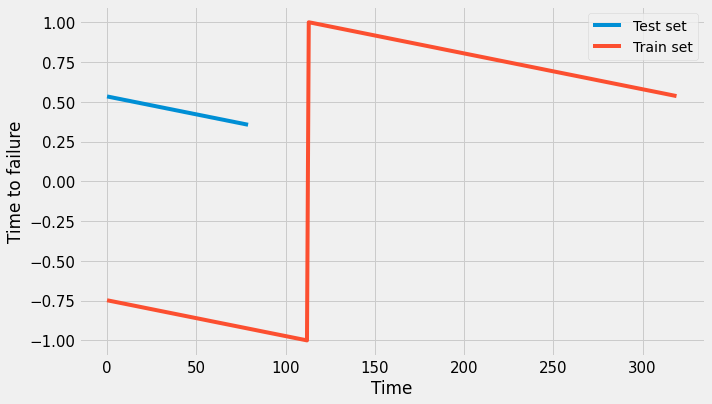

In [23]:
# Plot train and test data
plt.figure(figsize = (10, 6))
plt.plot(y_test)
plt.plot(y_train)
plt.xlabel('Time')
plt.ylabel('Time to failure')
plt.legend(['Test set', 'Train set'], loc='upper right')
print('Dimension of train data: ',X_train.shape)
print('Dimension of test data: ', X_test.shape)

In [40]:
#x_train=X_train.to_numpy()
#x_test=X_test.to_numpy()
print(type(X_test))
#x_train=X_train
#x_test=X_test

<class 'numpy.ndarray'>


In [90]:
#Convert to data format needed for modeling
x_train= X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
x_test= X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [25]:
print(x_train.shape)
print(x_test.shape)

(320, 1, 165)
(80, 1, 165)


In [26]:
x_test


array([[[ 0.68441815,  0.91795669,  0.92471775, ...,  0.3298774 ,
          0.2809636 , -0.59079284]],

       [[ 0.59368836,  0.89472274,  0.90238553, ...,  0.15000411,
         -0.02801781, -0.60613811]],

       [[ 0.65779093,  0.88134213,  0.88998921, ...,  0.22866782,
         -0.07567426,  0.33503836]],

       ...,

       [[ 0.41715976,  0.82427159,  0.83641992, ...,  0.26075866,
          0.27284629, -0.4629156 ]],

       [[ 0.47731755,  0.81953113,  0.83034412, ...,  0.1834115 ,
          0.04399057, -0.2685422 ]],

       [[ 0.31459566,  0.74172407,  0.75470588, ..., -0.00106969,
         -0.06258183, -0.02813299]]])

## Modeling LSTM, GRU, and Bidirectional networks

In [110]:
# Create BiLSTM model
def create_model_bilstm(units):
    model = Sequential()
    model.add(Bidirectional(LSTM(units = units,                             
              return_sequences=True),
              input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Bidirectional(LSTM(units = units)))
    model.add(Dense(1))
    #Compile model
    model.compile(loss='mse', optimizer='adam')
    return model
# Create LSTM or GRU model
def create_model(units, m):
    model = Sequential()
    model.add(m (units = units, return_sequences = True,
                input_shape = [x_train.shape[1], x_train.shape[2]]))
    model.add(Dropout(0.2))
    model.add(m (units = units))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1))
    #Compile model
    model.compile(loss='mse', optimizer='adam')
    return model
# BiLSTM
model_bilstm = create_model_bilstm(64)
# GRU and LSTM
model_gru = create_model(64, GRU)
model_lstm = create_model(64, LSTM)


In [66]:
model_bilstm.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 1, 128)            117760    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 216,705
Trainable params: 216,705
Non-trainable params: 0
_________________________________________________________________


In [83]:
# Fit BiLSTM, LSTM and GRU
def fit_model(model):
    early_stop = callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
    history = model.fit(x_train, y_train, epochs = 100,  
                        validation_split = 0.2, batch_size = 32, 
                        shuffle = False, callbacks = [early_stop])
    return history


#tensorflow.keras.callbacks.EarlyStopping(monitor = 'val_loss',

In [117]:
history_bilstm = fit_model(model_bilstm)
history_lstm = fit_model(model_lstm)
history_gru = fit_model(model_gru)

Epoch 1/100
8/8 [==============================] - 6s 175ms/step - loss: 1.0140 - val_loss: 0.6267
Epoch 2/100
8/8 [==============================] - 0s 6ms/step - loss: 0.5853 - val_loss: 0.2738
Epoch 3/100
8/8 [==============================] - 0s 11ms/step - loss: 0.5244 - val_loss: 0.1457
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 0.4965 - val_loss: 0.1916
Epoch 5/100
8/8 [==============================] - 0s 6ms/step - loss: 0.4265 - val_loss: 0.3444
Epoch 6/100
8/8 [==============================] - 0s 7ms/step - loss: 0.3401 - val_loss: 0.3673
Epoch 7/100
8/8 [==============================] - 0s 5ms/step - loss: 0.2979 - val_loss: 0.3065
Epoch 8/100
8/8 [==============================] - 0s 6ms/step - loss: 0.2796 - val_loss: 0.2918
Epoch 9/100
8/8 [==============================] - 0s 6ms/step - loss: 0.2550 - val_loss: 0.2571
Epoch 10/100
8/8 [==============================] - 0s 5ms/step - loss: 0.2395 - val_loss: 0.2424
Epoch 11/100
8/8 [========

# Plot train loss and validation loss

Evaluation of the model performance.

In [94]:
# Plot train loss and validation loss
def plot_loss (history,title):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
    plt.title(title)



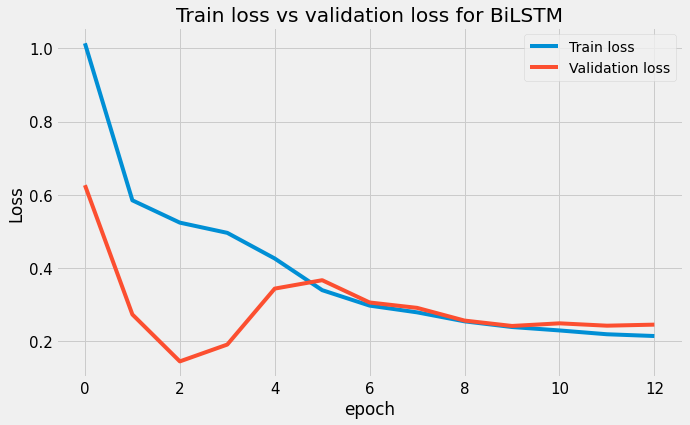

In [59]:
plot_loss (history_bilstm,'Train loss vs validation loss for BiLSTM')

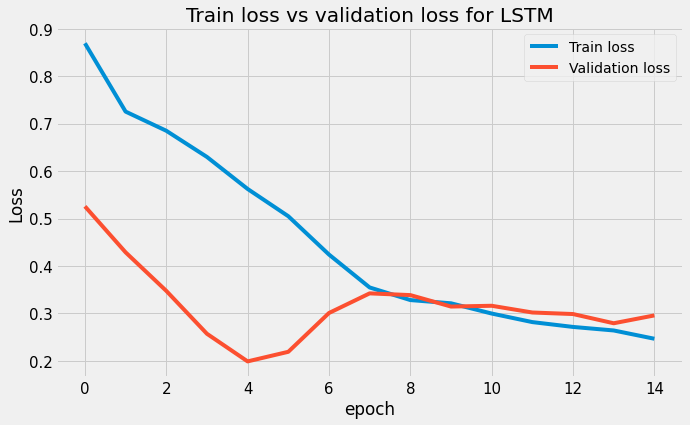

In [60]:
plot_loss (history_lstm,'Train loss vs validation loss for LSTM')

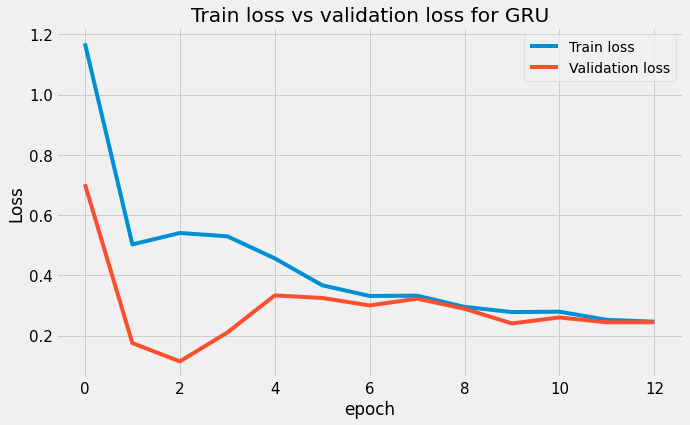

In [61]:
plot_loss (history_gru,'Train loss vs validation loss for GRU')

# Calculate RMSE and MAE


I will use two goodness-of-fit measures to evaluate the performance of the models, the Root Mean Square Error and the Mean Absolute Error.

In [ ]:
# Make prediction
def prediction(model):
    prediction = model.predict(x_test)
   # prediction = scaler_y.inverse_transform(prediction)
    return prediction

In [ ]:
prediction_bilstm = prediction(model_bilstm)
prediction_lstm = prediction(model_lstm)
prediction_gru = prediction(model_gru)

In [126]:
# Define a function to calculate MAE and RMSE
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    print(model_name + ':')
    print('Mean Absolute Error: ',mae)
    print('Root Mean Square Error: ',rmse)
    print('')
evaluate_prediction(prediction_bilstm, y_test, 'Bidirectional LSTM')
evaluate_prediction(prediction_lstm, y_test, 'LSTM')
evaluate_prediction(prediction_gru, y_test, 'GRU')

Bidirectional LSTM:
Mean Absolute Error:  0.3977925461238827
Root Mean Square Error:  0.40086040406762563

LSTM:
Mean Absolute Error:  0.43161014208911175
Root Mean Square Error:  0.434906529598335

GRU:
Mean Absolute Error:  0.41488331714520416
Root Mean Square Error:  0.41770174105754376



## Parameter tuning 

Here are some hyperparameters that can be optimized. For the purpose of this analysis I will only tune the Learning rate and the number of units ina dense layer.

1.  NUMBER OF NODES AND HIDDEN LAYERS
As a general rule of thumb, one hidden layer will work with most simple problems and two layers with reasonably complex ones. Also, while many nodes (with regularization techniques) within a layer can increase accuracy, fewer number of nodes may cause underfitting.


2. NUMBER OF UNITS IN A DENSE LAYER

As a general rule of thumb, one hidden layer will work with most simple problems and two layers with reasonably complex ones. Also, while many nodes (with regularization techniques) within a layer can increase accuracy, fewer number of nodes may cause underfitting.
Method: model.add(Dense(10, …))


3. DROPOUT

Every LSTM layer should be accompanied by a dropout layer. Such a layer helps avoid overfitting in training by bypassing randomly selected neurons, thereby reducing the sensitivity to specific weights of the individual neurons. While dropout layers can be used with input layers, they shouldn’t be used with output layers as that may mess up the output from the model and the calculation of error. While adding more complexity may risk overfitting (by increasing nodes in dense layers or adding more number of dense layers and have poor validation accuracy), this can be addressed by adding dropout.
A good starting point is 20% but the dropout value should be kept small (up to 50%). The 20% value is widely accepted as the best compromise between preventing model overfitting and retaining model accuracy.

Method: model.add(LSTM(…, dropout=0.5))

4. WEIGHT INITIALIZATION

Weights should finally be initialized randomly to small numbers (an expectation of the stochastic optimization algorithm, otherwise known as stochastic gradient descent) to harness randomness in the search process.

5. DECAY RATE

The weight decay can be added in the weight update rule that makes the weights decay to zero exponentially, if no other weight update is scheduled. After each update, the weights are multiplied by a factor slightly less than 1, thereby preventing them from growing to huge. This specifies regularization in the network.
The default value of 0.97 should be enough to start off.


6. ACTIVATION FUNCTION

Again, choice of activation layer depends on the application, however, the rectifier activation function is most popular. Specific situations entail specific functions. For example, sigmoid activation is used in the output layer for binary predictions and softmax is used to make multi-class predictions (softmax gives your ability the ability to interpret the outputs as probabilities.
Method: The process is to create user defined functions and have it return the output associated with any specific activation function. 

For example, here is a sigmoid activation function:
def sigmoid(x):
return 1/(1+np.exp(-x))
Sigmoid (log-sigmoid) and hyperbolic tangent are some of the more popular activation functions adopted in LSTM blocks.

7. LEARNING RATE

This hyperparameter defines how quickly the network updates its parameters. Setting a higher learning rate accelerates the learning but the model may not converge (a state during training where the loss settles to within an error range around the final value), or even diverge. Conversely, a lower rate will slow down the learning drastically as steps towards the minimum of loss function will be tiny, but will allow the model to converge smoothly.
Usually a decaying learning rate is preferred and this hyperparameter is used in the training phase and has a small positive value, mostly between 0.0 and 0.1.

8. MOMENTUM

Momentum is a unique hyperparameter which allows the accumulation of the gradients of the past steps to determine the direction to go with, instead of using the gradient of only the current step to guide the search.
Typically, the value is between 0.5 to 0.9

9. NUMBER OF EPOCHS

This hyperparameters sets how many complete iterations of the dataset is to be run. While theoretically, this number can be set to an integer value between one and infinity, this should be increased until the validation accuracy starts to decrease even though training accuracy increases (and hence risking overfitting).
A pro move is to employ the early stopping method to first specify a large number of training epochs and stop training once the model performance stops improving by a pre-set threshold on the validation dataset.



10. BATCH SIZE

This hyperparameter defines the number of samples to work on before the internal parameters of the model are updated. Large sizes make large gradient steps compared to smaller ones for the same number of samples “seen”.
Widely accepted, a good default value for batch size is 32. For experimentation, you can try multiples of 32, such as 64, 128 and 256.

In [ ]:
!pip install keras-tuner

In [ ]:
!pip install opencv-contrib-python

# Parameter tuning for Biderectional model


The hyperparameters that I will tune are the number of units and the learning rate. The two methods that I will use are Random Search and Bayesian Optimization both from the Keras tuner package.

## Tuning BiLSTM with Keras Random Search

In [131]:
#from tensorflow.keras import layers
from keras_tuner import RandomSearch
from tensorflow.keras import layers
from tensorflow import keras
import numpy as np


In [243]:
##### Create BiLSTM model with hyperparameter range.
units=64
def model_bilstm_hp(hp):
    model = Sequential()
    model.add(Bidirectional(LSTM(units = hp.Int("units", min_value=32, max_value=512, step=32),                             
              return_sequences=True),
              input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Bidirectional(LSTM(units = hp.Int("units", min_value=32, max_value=512, step=32))))
    #model.add(layers.Dense(units=hp.Int("units", min_value=32, max_value=512, step=32),activation="relu"))
    model.add(Dense(1))
    #Compile model
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])),loss='mse')
    
    return model



In [244]:

from keras_tuner import RandomSearch


tuner_RS = RandomSearch(
    model_bilstm_hp,
    objective='loss',
    max_trials=3,
    executions_per_trial=2,
    overwrite=True,
    directory='/Users/jose1/Desktop/SpringboardLalli/PROJECT_2/P2_Earthquake',
    project_name="Hyperparameter_search_biderectional_Final")

In [245]:
tuner_RS.search_space_summary()

Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [246]:
early_stop = callbacks.EarlyStopping(monitor = 'val_loss',patience = 10)
tuner_RS.search(x_train, y_train, epochs=100, validation_data=(x_test, y_test),validation_split = 0.2, batch_size = 32, 
                        shuffle = False, callbacks = [early_stop])

Trial 3 Complete [00h 00m 59s]
loss: 0.728107750415802

Best loss So Far: 0.22472556680440903
Total elapsed time: 00h 01m 57s
INFO:tensorflow:Oracle triggered exit


In [248]:
#Epochs =100
tuner_RS.results_summary()

Results summary
Results in /Users/jose1/Desktop/SpringboardLalli/PROJECT_2/P2_Earthquake/Hyperparameter_search_biderectional_Final
Showing 10 best trials
Objective(name='loss', direction='min')
Trial summary
Hyperparameters:
units: 448
learning_rate: 0.001
Score: 0.22472556680440903
Trial summary
Hyperparameters:
units: 192
learning_rate: 0.0001
Score: 0.3131140172481537
Trial summary
Hyperparameters:
units: 384
learning_rate: 0.01
Score: 0.728107750415802


The selected optimized model with Keras tuner is:

Hyperparameters:

units: 448

learning_rate: 0.001

Score: 0.22472556680440903

In [249]:
units=448
def create_model_bilstm_tuner(units):
    model = Sequential()
    model.add(Bidirectional(LSTM(units = units,                             
              return_sequences=True),
              input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Bidirectional(LSTM(units = units)))
    #model.add(layers.Dense(units=units,activation="relu"))
    model.add(Dense(1))
    #Compile model
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),loss='mse')
    
    #model.compile(loss='mse', optimizer='adam')
    return model

In [250]:
# BiLSTM
model_bilstm_tuner = create_model_bilstm_tuner(units)

In [251]:
history_bilstm_tuner = fit_model(model_bilstm_tuner)

Epoch 1/100
8/8 [==============================] - 5s 190ms/step - loss: 0.7872 - val_loss: 0.3901
Epoch 2/100
8/8 [==============================] - 0s 35ms/step - loss: 1.5871 - val_loss: 0.5402
Epoch 3/100
8/8 [==============================] - 0s 34ms/step - loss: 0.5071 - val_loss: 0.2324
Epoch 4/100
8/8 [==============================] - 0s 33ms/step - loss: 0.4183 - val_loss: 0.2032
Epoch 5/100
8/8 [==============================] - 0s 33ms/step - loss: 0.4189 - val_loss: 0.4083
Epoch 6/100
8/8 [==============================] - 0s 34ms/step - loss: 0.3412 - val_loss: 0.2644
Epoch 7/100
8/8 [==============================] - 0s 35ms/step - loss: 0.3239 - val_loss: 0.2444
Epoch 8/100
8/8 [==============================] - 0s 35ms/step - loss: 0.3100 - val_loss: 0.2867
Epoch 9/100
8/8 [==============================] - 0s 33ms/step - loss: 0.2729 - val_loss: 0.2398
Epoch 10/100
8/8 [==============================] - 0s 32ms/step - loss: 0.2646 - val_loss: 0.2450
Epoch 11/100
8/8 [

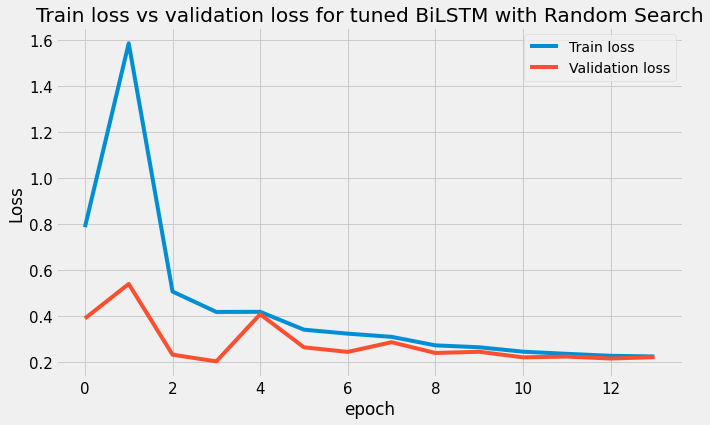

In [252]:
plot_loss (history_bilstm_tuner,'Train loss vs validation loss for tuned BiLSTM with Random Search')

In [253]:
# Make prediction
def prediction_Tuned(model):
    prediction = model.predict(x_test)
   # prediction = scaler_y.inverse_transform(prediction)
    return prediction

In [254]:
prediction_bilstm_Tuned = prediction_Tuned(model_bilstm_tuner)


In [255]:
evaluate_prediction(prediction_bilstm_Tuned, y_test, 'Bidirectional LSTM Random Search tuned')

Bidirectional LSTM Random Search tuned:
Mean Absolute Error:  0.641288100250252
Root Mean Square Error:  0.7284742848984478



Plot of the Predicted values.

In [256]:
#Rescale

y_pred_bilstm_NS_tuned=scaler.inverse_transform(prediction_bilstm_Tuned )

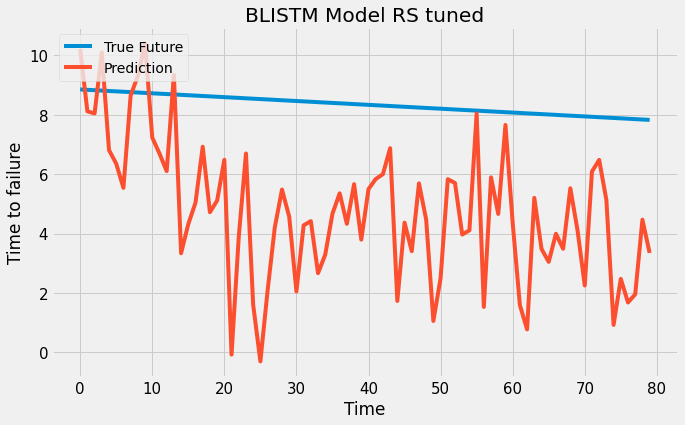

In [257]:

plot_future(y_pred_bilstm_NS_tuned, y_test_NS,"BLISTM Model RS tuned")

## Tuning BiLSTM with Keras BayesianOptimization

I will use the same defined model (model_bilstm_hp) and change the tuner to BayesianOptimization.

In [266]:
####https://keras.io/guides/keras_tuner/getting_started/
from keras_tuner import BayesianOptimization


tuner_BO = BayesianOptimization(
    model_bilstm_hp,
    objective='loss',
    max_trials=3,
    executions_per_trial=2,
    overwrite=True,
    directory='/Users/jose1/Desktop/SpringboardLalli/PROJECT_2/P2_Earthquake',
    project_name="Hyperparameter_Bayesian_biderectional_BO_Final")


In [267]:
tuner_BO.search_space_summary()

Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [268]:
early_stop = callbacks.EarlyStopping(monitor = 'val_loss',patience = 10)
tuner_BO.search(x_train, y_train, epochs=100, validation_data=(x_test, y_test),validation_split = 0.2, batch_size = 32, 
                        shuffle = False, callbacks = [early_stop])

Trial 3 Complete [00h 00m 26s]
loss: 0.7304695844650269

Best loss So Far: 0.22466743737459183
Total elapsed time: 00h 01m 07s
INFO:tensorflow:Oracle triggered exit


In [270]:
#Epochs =100
tuner_BO.results_summary()

Results summary
Results in /Users/jose1/Desktop/SpringboardLalli/PROJECT_2/P2_Earthquake/Hyperparameter_Bayesian_biderectional_BO_Final
Showing 10 best trials
Objective(name='loss', direction='min')
Trial summary
Hyperparameters:
units: 448
learning_rate: 0.001
Score: 0.22466743737459183
Trial summary
Hyperparameters:
units: 32
learning_rate: 0.0001
Score: 0.37453441321849823
Trial summary
Hyperparameters:
units: 512
learning_rate: 0.01
Score: 0.7304695844650269


Parameters used:
Hyperparameters:

units: 448

learning_rate: 0.001

Score: 0.22466743737459183


Model with hyperparameters found with BayesianOptimization

In [271]:
units=448

def create_model_bilstm_tuner_B(units):
    model = Sequential()
    model.add(Bidirectional(LSTM(units = units,                             
              return_sequences=True),
              input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Bidirectional(LSTM(units = units)))
    #model.add(layers.Dense(units=units,activation="relu"))
    model.add(Dense(1))
    #Compile model
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),loss='mse')
    
    #model.compile(loss='mse', optimizer='adam')
    return model

In [272]:
# BiLSTM Bayesian tuner
model_bilstm_tuner_B = create_model_bilstm_tuner_B(units)

In [273]:
history_bilstm_tuner_B = fit_model(model_bilstm_tuner_B)

Epoch 1/100
8/8 [==============================] - 6s 200ms/step - loss: 0.8000 - val_loss: 0.4360
Epoch 2/100
8/8 [==============================] - 0s 34ms/step - loss: 1.5620 - val_loss: 0.5468
Epoch 3/100
8/8 [==============================] - 0s 34ms/step - loss: 0.5233 - val_loss: 0.2644
Epoch 4/100
8/8 [==============================] - 0s 33ms/step - loss: 0.4017 - val_loss: 0.1924
Epoch 5/100
8/8 [==============================] - 0s 33ms/step - loss: 0.4177 - val_loss: 0.3984
Epoch 6/100
8/8 [==============================] - 0s 32ms/step - loss: 0.3440 - val_loss: 0.2831
Epoch 7/100
8/8 [==============================] - 0s 34ms/step - loss: 0.3184 - val_loss: 0.2415
Epoch 8/100
8/8 [==============================] - 0s 34ms/step - loss: 0.3104 - val_loss: 0.2878
Epoch 9/100
8/8 [==============================] - 0s 33ms/step - loss: 0.2741 - val_loss: 0.2469
Epoch 10/100
8/8 [==============================] - 0s 32ms/step - loss: 0.2632 - val_loss: 0.2435
Epoch 11/100
8/8 [

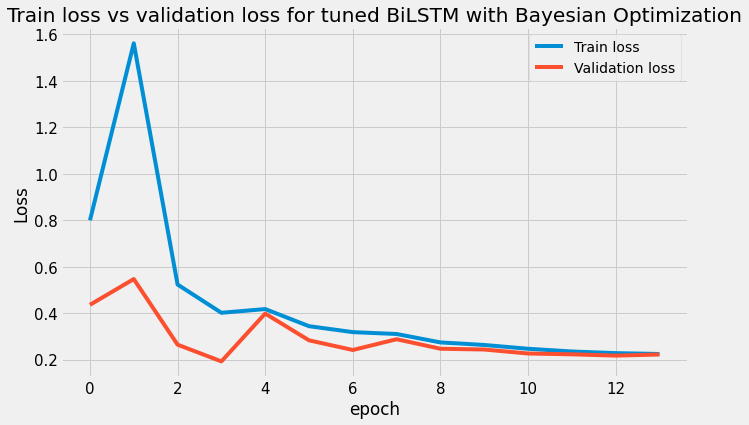

In [274]:
plot_loss (history_bilstm_tuner_B,'Train loss vs validation loss for tuned BiLSTM with Bayesian Optimization')

In [275]:
###  Prediction Keras Bayesian tuner model
prediction_bilstm_tuner_B = prediction_Tuned(model_bilstm_tuner_B)

WARNING:tensorflow:5 out of the last 16 calls to <function Model.make_predict_function.<locals>.predict_function at 0x17d8ed430> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.

In [306]:
## Evaluate Prediction

evaluate_prediction(prediction_bilstm_tuner_B, y_test, 'Bidirectional LSTM with Bayesian Optimization')

Bidirectional LSTM with Bayesian Optimization:
Mean Absolute Error:  0.6461497604238804
Root Mean Square Error:  0.7341609924695007



Plot of predicted values

In [277]:
#Rescale

y_pred_bilstm_NS_tuner_B=scaler.inverse_transform(prediction_bilstm_tuner_B )

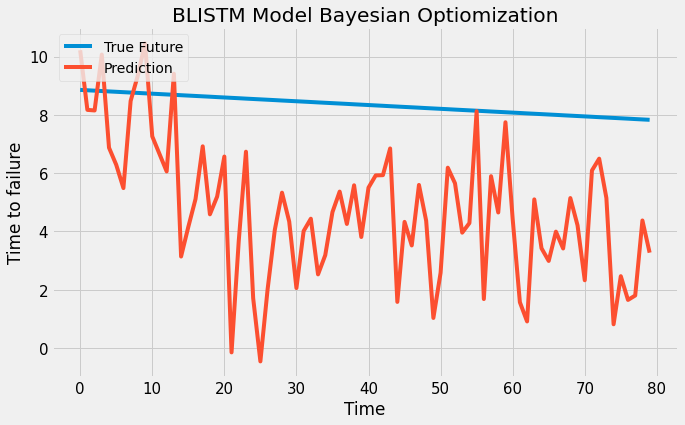

In [278]:
plot_future(y_pred_bilstm_NS_tuner_B, y_test_NS,"BLISTM Model Bayesian Optiomization")

## Hyperparameter Tuning for GRU model

## Tuning GRU with Keras Random Search

First I create the GRU model with the hyperparameter range.

In [279]:
units=64
def create_GRU_model_hp(hp):
    model = Sequential()
    model.add(GRU (units = hp.Int("units", min_value=32, max_value=512, step=32), return_sequences = True,
                input_shape = [x_train.shape[1], x_train.shape[2]]))
    model.add(Dropout(0.2))
    model.add(GRU (units = hp.Int("units", min_value=32, max_value=512, step=32)))
    model.add(Dropout(0.2))
    #model.add(layers.Dense(units=hp.Int("units", min_value=32, max_value=512, step=32),activation="relu"))
    
    model.add(Dense(units = 1))
    #Compile model
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])),loss='mse')
    
    #model.compile(loss='mse', optimizer='adam')
    return model



In [280]:
tuner_GRU = RandomSearch(
    create_GRU_model_hp,
    objective='loss',
    max_trials=3,
    executions_per_trial=2,
    overwrite=True,
    directory='/Users/jose1/Desktop/SpringboardLalli/PROJECT_2/P2_Earthquake',
    project_name="Hyperparameter_search_GRU_RS_Final")

In [281]:
tuner_GRU.search_space_summary()

Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [282]:
early_stop = callbacks.EarlyStopping(monitor = 'val_loss',patience = 10)
tuner_GRU.search(x_train, y_train, epochs=100, validation_data=(x_test, y_test),validation_split = 0.2, batch_size = 32, 
                        shuffle = False, callbacks = [early_stop])

Trial 3 Complete [00h 00m 11s]
loss: 0.17863204330205917

Best loss So Far: 0.17863204330205917
Total elapsed time: 00h 00m 30s
INFO:tensorflow:Oracle triggered exit


In [283]:

tuner_GRU.results_summary()

Results summary
Results in /Users/jose1/Desktop/SpringboardLalli/PROJECT_2/P2_Earthquake/Hyperparameter_search_GRU_RS_Final
Showing 10 best trials
Objective(name='loss', direction='min')
Trial summary
Hyperparameters:
units: 256
learning_rate: 0.01
Score: 0.17863204330205917
Trial summary
Hyperparameters:
units: 160
learning_rate: 0.001
Score: 0.24812711030244827
Trial summary
Hyperparameters:
units: 96
learning_rate: 0.0001
Score: 0.4183855801820755


The selected optimized model with Keras tuner is:

Hyperparameters:

units: 256

learning_rate: 0.01

Score: 0.17863204330205917

GRU Model with hyperparameters found with Random Search.

In [285]:
units=256
def create_GRU_model_R(units):
    model = Sequential()
    model.add(GRU (units = units, return_sequences = True,
                input_shape = [x_train.shape[1], x_train.shape[2]]))
    model.add(Dropout(0.2))
    model.add(GRU (units = units))
    model.add(Dropout(0.2))
    #model.add(layers.Dense(units=units,activation="relu"))
    model.add(Dense(units = 1))
   
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),loss='mse')
    return model



In [286]:
# BiLSTM Bayesian tuner
model_GRU_tuner_RS = create_GRU_model_R(units)

In [287]:
history_GRU_tuner_RS = fit_model(model_GRU_tuner_RS)

Epoch 1/100
8/8 [==============================] - 3s 93ms/step - loss: 7.1091 - val_loss: 0.4498
Epoch 2/100
8/8 [==============================] - 0s 6ms/step - loss: 0.7699 - val_loss: 0.4469
Epoch 3/100
8/8 [==============================] - 0s 6ms/step - loss: 0.7333 - val_loss: 0.3847
Epoch 4/100
8/8 [==============================] - 0s 6ms/step - loss: 0.7276 - val_loss: 0.3550
Epoch 5/100
8/8 [==============================] - 0s 6ms/step - loss: 0.7240 - val_loss: 0.3373
Epoch 6/100
8/8 [==============================] - 0s 6ms/step - loss: 0.7144 - val_loss: 0.3181
Epoch 7/100
8/8 [==============================] - 0s 6ms/step - loss: 0.7034 - val_loss: 0.2886
Epoch 8/100
8/8 [==============================] - 0s 6ms/step - loss: 0.6654 - val_loss: 0.2347
Epoch 9/100
8/8 [==============================] - 0s 6ms/step - loss: 0.6188 - val_loss: 0.2262
Epoch 10/100
8/8 [==============================] - 0s 7ms/step - loss: 0.5059 - val_loss: 0.2578
Epoch 11/100
8/8 [==========

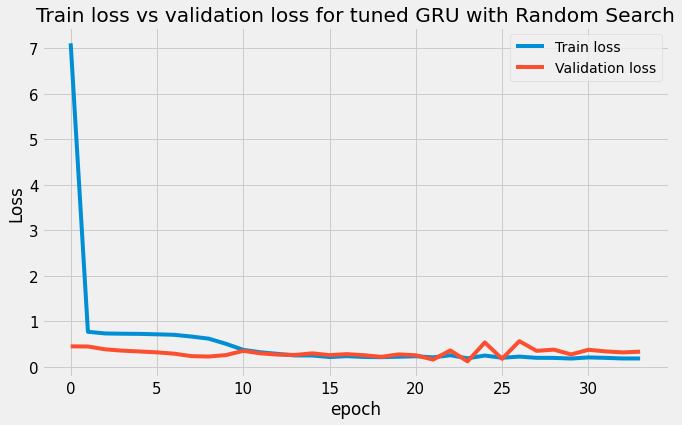

In [288]:

plot_loss (history_GRU_tuner_RS,'Train loss vs validation loss for tuned GRU with Random Search')

In [289]:
###  Prediction Keras Bayesian tuner model
prediction_GRU_tuner_RS = prediction(model_GRU_tuner_RS)

In [309]:
## Evaluate Prediction

evaluate_prediction(prediction_GRU_tuner_RS, y_test, 'GRU_tuner Random search')

GRU_tuner Random search:
Mean Absolute Error:  0.8621814099712666
Root Mean Square Error:  0.9647753462378025



Plot of predicted values

In [291]:
#Rescale

y_pred_GRU_NS_tuner_RS=scaler.inverse_transform(prediction_GRU_tuner_RS)

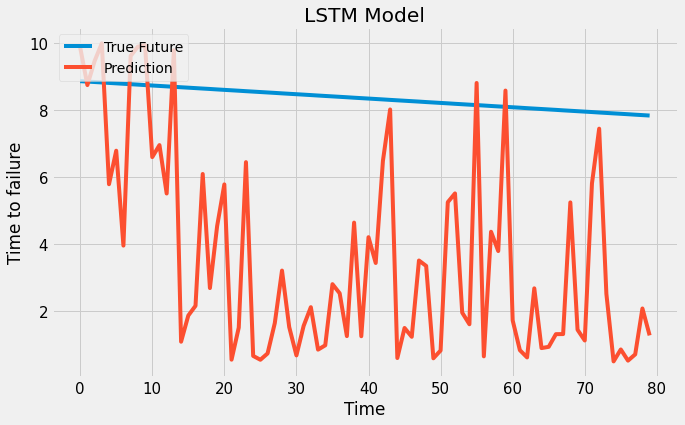

In [292]:
plot_future(y_pred_GRU_NS_tuner_RS, y_test_NS,"LSTM Model")



## Tuning GRU with Keras Bayesian Optimization

I will keep the same model definition used with the hyperparameter Random search.

In [293]:
tuner_GRU_BO =  BayesianOptimization(
    create_GRU_model_hp,
    objective='loss',
    max_trials=3,
    executions_per_trial=2,
    overwrite=True,
    directory='/Users/jose1/Desktop/SpringboardLalli/PROJECT_2/P2_Earthquake',
    project_name="Hyperparameter_search_GRU_BO_Final")

In [294]:
tuner_GRU_BO.search_space_summary()

Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [295]:
early_stop = callbacks.EarlyStopping(monitor = 'val_loss',patience = 10)
tuner_GRU_BO.search(x_train, y_train, epochs=100, validation_data=(x_test, y_test),validation_split = 0.2, batch_size = 32, 
                        shuffle = False, callbacks = [early_stop])

Trial 3 Complete [00h 00m 17s]
loss: 0.7260081171989441

Best loss So Far: 0.18625755608081818
Total elapsed time: 00h 00m 41s
INFO:tensorflow:Oracle triggered exit


In [222]:
#Epochs =100
tuner_GRU_BO.results_summary()

Results summary
Results in /Users/jose1/Desktop/SpringboardLalli/PROJECT_2/P2_Earthquake/Hyperparameter_search_GRU_BO_Final
Showing 10 best trials
Objective(name='loss', direction='min')
Trial summary
Hyperparameters:
units: 128
learning_rate: 0.001
Score: 0.4471256583929062
Trial summary
Hyperparameters:
units: 352
learning_rate: 0.001
Score: 0.45557452738285065
Trial summary
Hyperparameters:
units: 32
learning_rate: 0.01
Score: 0.7386903762817383


The selected optimized model with Keras tuner is:

Hyperparameters:

units: 128

learning_rate: 0.001

Score: 0.4471256583929062

In [297]:
units=128
def create_GRU_model_BO(units):
    model = Sequential()
    model.add(GRU (units = units, return_sequences = True,
                input_shape = [x_train.shape[1], x_train.shape[2]]))
    model.add(Dropout(0.2))
    model.add(GRU (units = units))
    model.add(Dropout(0.2))
  
    model.add(Dense(units = 1))
   
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),loss='mse')
    return model

In [298]:
# BiLSTM Bayesian tuner
model_GRU_tuner_BO = create_GRU_model_BO(units)

In [299]:
history_GRU_tuner_BO= fit_model(model_GRU_tuner_BO)

Epoch 1/100
8/8 [==============================] - 3s 95ms/step - loss: 1.4874 - val_loss: 0.2805
Epoch 2/100
8/8 [==============================] - 0s 5ms/step - loss: 0.5392 - val_loss: 0.0372
Epoch 3/100
8/8 [==============================] - 0s 5ms/step - loss: 0.7146 - val_loss: 0.2399
Epoch 4/100
8/8 [==============================] - 0s 5ms/step - loss: 0.5120 - val_loss: 0.3179
Epoch 5/100
8/8 [==============================] - 0s 5ms/step - loss: 0.3848 - val_loss: 0.2580
Epoch 6/100
8/8 [==============================] - 0s 6ms/step - loss: 0.3731 - val_loss: 0.3275
Epoch 7/100
8/8 [==============================] - 0s 5ms/step - loss: 0.3342 - val_loss: 0.3146
Epoch 8/100
8/8 [==============================] - 0s 5ms/step - loss: 0.3090 - val_loss: 0.2499
Epoch 9/100
8/8 [==============================] - 0s 5ms/step - loss: 0.3043 - val_loss: 0.2285
Epoch 10/100
8/8 [==============================] - 0s 5ms/step - loss: 0.2691 - val_loss: 0.2185
Epoch 11/100
8/8 [==========

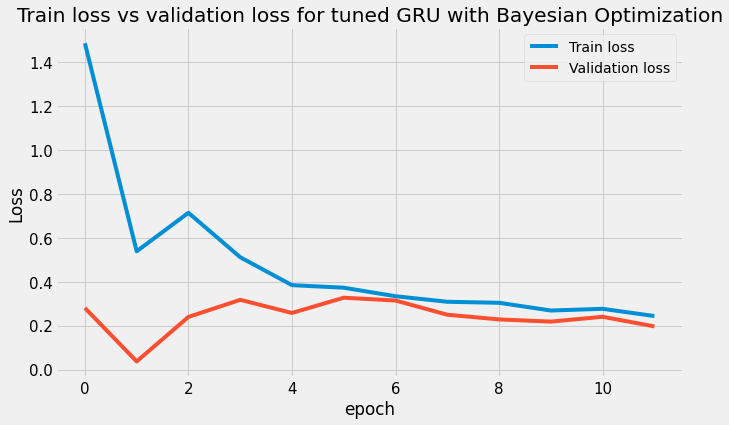

In [300]:
plot_loss (history_GRU_tuner_BO,'Train loss vs validation loss for tuned GRU with Bayesian Optimization')

In [301]:
###  Prediction Keras Bayesian tuner model
prediction_GRU_tuner_BO = prediction(model_GRU_tuner_BO)

In [307]:
## Evaluate Prediction

evaluate_prediction(prediction_GRU_tuner_BO, y_test, 'GRU_tuner Bayesian Optimization')

GRU_tuner Bayesian Optimization:
Mean Absolute Error:  0.5550329646518657
Root Mean Square Error:  0.639126322996294



Plot of predicted values

In [303]:
#Rescale


y_pred_GRU_NS_tuner_BO=scaler.inverse_transform(prediction_GRU_tuner_BO)

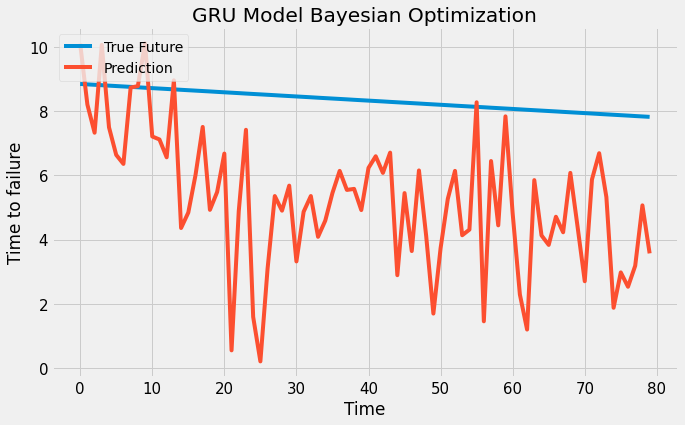

In [304]:
plot_future(y_pred_GRU_NS_tuner_BO, y_test_NS,"GRU Model Bayesian Optimization")

## Model Metrics Evaluation

Comparison of the metrics of the tuned models, BiLSTM and GRU models

In [308]:
evaluate_prediction(prediction_bilstm_Tuned, y_test, 'Bidirectional LSTM Random Search tuned')
evaluate_prediction(prediction_bilstm_tuner_B, y_test, 'Bidirectional LSTM with Bayesian Optimization')
evaluate_prediction(prediction_GRU_tuner_RS, y_test, 'GRU Random search')
evaluate_prediction(prediction_GRU_tuner_BO, y_test, 'GRU_tuner Bayesian Optimization')

Bidirectional LSTM Random Search tuned:
Mean Absolute Error:  0.641288100250252
Root Mean Square Error:  0.7284742848984478

Bidirectional LSTM with Bayesian Optimization:
Mean Absolute Error:  0.6461497604238804
Root Mean Square Error:  0.7341609924695007

GRU Random search:
Mean Absolute Error:  0.8621814099712666
Root Mean Square Error:  0.9647753462378025

GRU_tuner Bayesian Optimization:
Mean Absolute Error:  0.5550329646518657
Root Mean Square Error:  0.639126322996294



Even though the Train and Valitation loss graph show an improvement for the BiLSTM model the MAE and the RMSE have increased compared to the first model before the hyper paramenter tuning.

For the GRU model the Train and Validation graph have converge closer in the first model before the hyperparameter tunig and also the RMSE and the MAE increased.



# Model selected

The model that I will select is the BiLSTM model with 64 units, the default learning rate of 0.01 and loss = MSE and Adam optimizer.

In [ ]:
# Create BiLSTM model
def create_model_bilstm(units):
    model = Sequential()
    model.add(Bidirectional(LSTM(units = units,                             
              return_sequences=True),
              input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Bidirectional(LSTM(units = units)))
    model.add(Dense(1))
    #Compile model
    model.compile(loss='mse', optimizer='adam')
    return model

QUESTIONS:
1.-  Do I need to consider how the predictions look for each of the models?
2.- Do I need to add the prediction sectio of the selected fimal model?


## Prediction

Prediction using BiLSTM, LSTM and GRU models. Then, a plot of true future (test data) vs prediction the three models is shown too.

In [ ]:
# Make prediction
def prediction(model):
    prediction = model.predict(x_test)
   # prediction = scaler_y.inverse_transform(prediction)
    return prediction



In [ ]:
prediction_bilstm = prediction(model_bilstm)
prediction_lstm = prediction(model_lstm)
prediction_gru = prediction(model_gru)



In [ ]:
y_pred_bilstm_NS=scaler.inverse_transform(prediction_bilstm)
y_test_NS=scaler.inverse_transform(y_test)

y_pred_bilstm_lstm_NS=scaler.inverse_transform(prediction_lstm)
y_pred_bilstm_gru_NS=scaler.inverse_transform(prediction_gru)

In [ ]:
# Plot true future vs prediction
def plot_future(prediction, y_test,title):
    plt.figure(figsize=(10, 6))
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y_test), 
             label='True Future')     
    plt.plot(np.arange(range_future),np.array(prediction),
            label='Prediction')
    plt.legend(loc='upper left')
    plt.xlabel('Time')
    plt.ylabel('Time to failure')
    plt.title(title)
plot_future(y_pred_bilstm_NS, y_test_NS,"BLISTM Model")
plot_future(y_pred_bilstm_lstm_NS, y_test_NS,"LSTM Model")
plot_future(y_pred_bilstm_gru_NS, y_test_NS,"GRU Model")